The purpose of this notebook is to evaluate GPDs $G_q(x,\eta,t)$ as well as their conformal moments $\mathbb{G}_q(n,\eta,t)$, where, for a generic GPD, we have its conformal moment expansion
\begin{equation}
G_q(x,\eta,t)=\sum_{n=0}^\infty (-1)^{n}p_n(x,\eta)\mathbb{F}_q(n,\eta,t),\qquad G_g(x,\eta,t)=\sum_{n=1}^\infty (-1)^{n-1}\, {^g\!p}_n(x,\eta) \mathbb{G}_g(n,\eta,t),
\end{equation}
where $G=H,E,\widetilde{H},\widetilde{E},H^T,E^T,\widetilde{H}^T,\widetilde{E}^T$.

To this end, we utilize the MSTW (AAC) unpolarized (polarized) PDF parametrization as input. The conformal moments are obtained by Reggeized $x$ integrals over PDFs at some input scale $\mu_0=1$ GeV and evolved using the pertinent RGEs, currently up to next-to-leading order. The GPDs are reconstructed using the expansion in conformal partial waves and Mellin-Barnes integrals to resum the expansion in conformal moments and partial waves.

Plots of conformal moments $\mathbb{G}(n,\eta,t)$ in momentum space

In [ ]:
# Generate the plot folder if not done manually
import stringy_gpds.config as cfg

plot_path = cfg.PLOT_PATH
if not plot_path.exists():
    plot_path.mkdir(parents=True)

In [3]:
from stringy_gpds.plot import plot_moments_on_grid

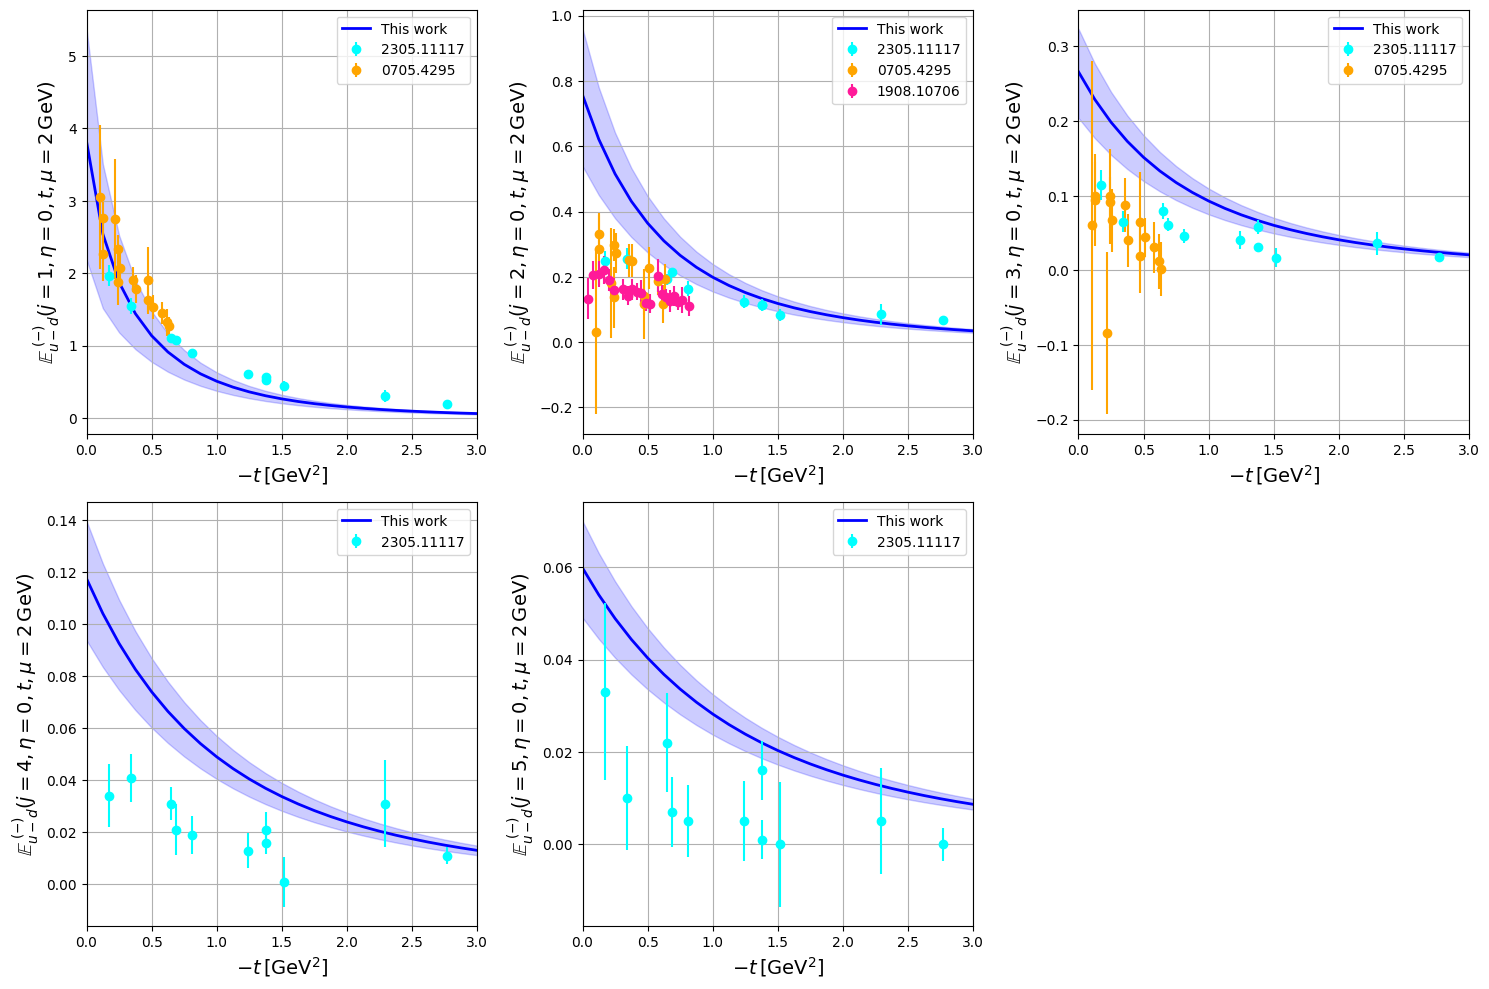

In [5]:
#non_singlet_isovector
y_label = "$\\mathbb{{E}}_{{u-d}}^{{\\,\\,(-)}}$"
moment_type = "non_singlet_isovector"
moment_label = "B"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

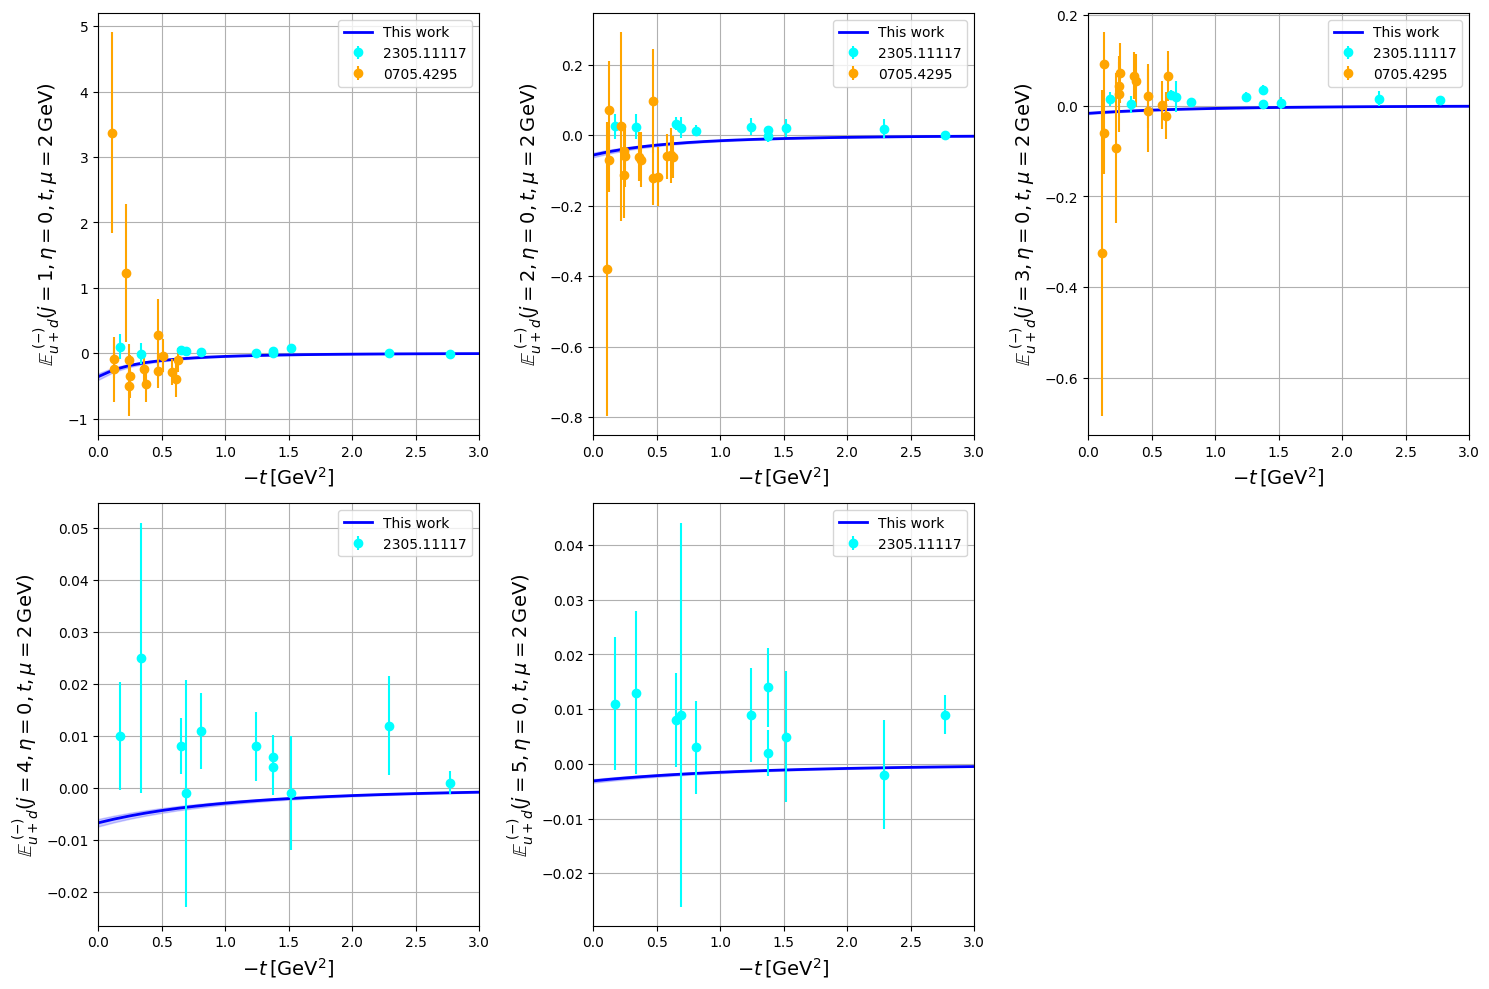

In [6]:
# non_singlet_isoscalar
y_label = "$\\mathbb{{E}}_{{u+d}}^{{\\,\\,(-)}}$"
moment_type = "non_singlet_isoscalar"
moment_label = "B"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

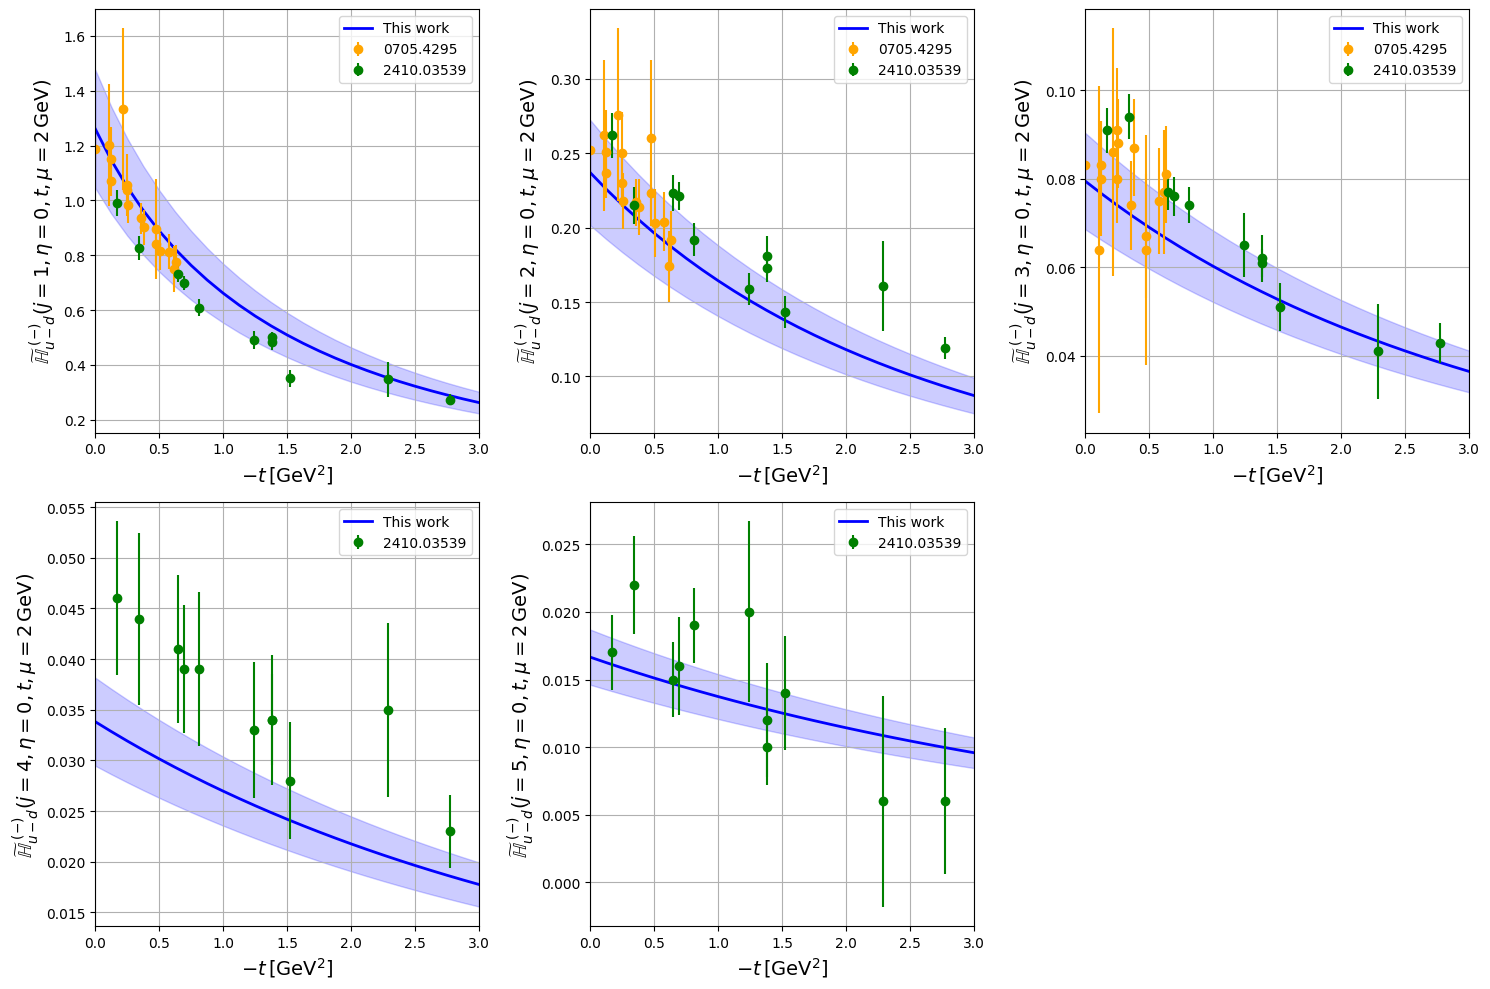

In [7]:
#non_singlet_isovector axial
y_label = "$\\widetilde{\\mathbb{{H}}}_{{u-d}}^{{\\,\\,(-)}}$"
moment_type = "non_singlet_isovector"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

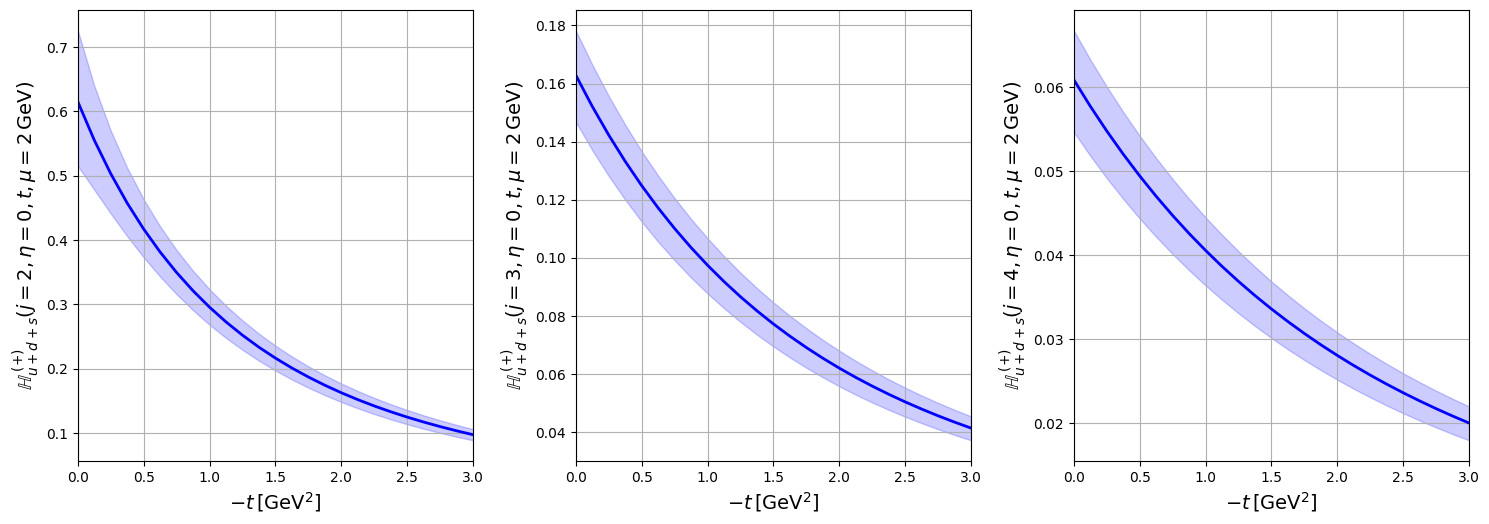

In [ ]:
# Sea Quark singlet
y_label = "$\\mathbb{{H}}_{{u+d+s}}^{{\\,\\,(+)}}$"
moment_type = "singlet"
moment_label = "A"

plot_moments_on_grid(0,y_label,3,1,"quark",moment_type, moment_label,"nlo",25)

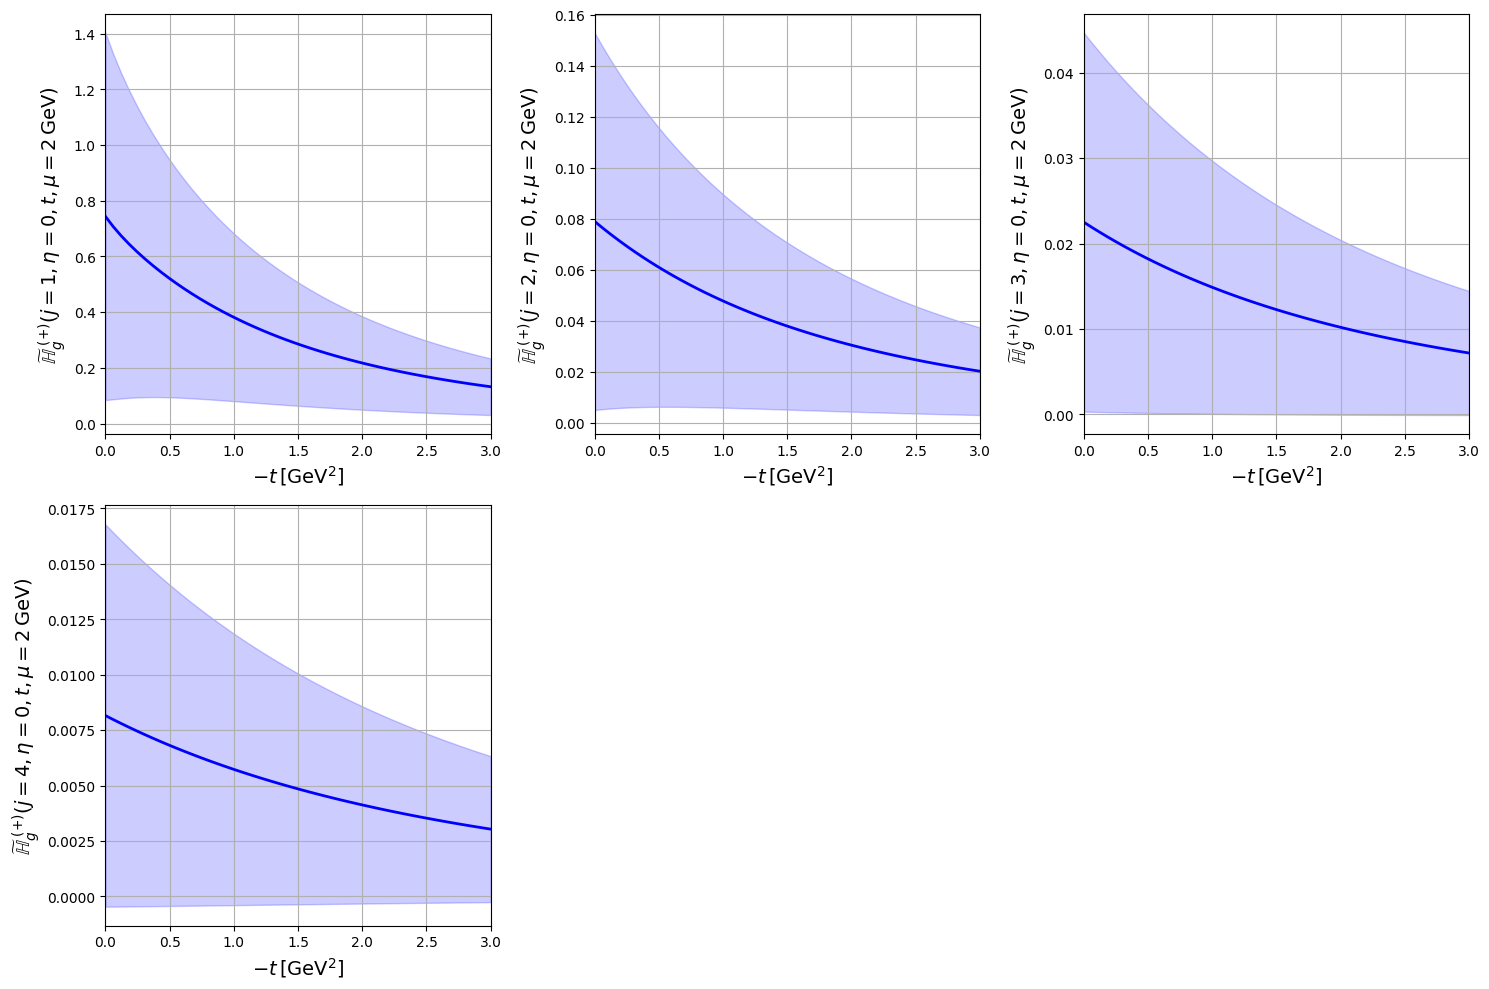

In [ ]:
# Gluon singlet axial
y_label = "$\\widetilde{\\mathbb{{H}}}_{{g}}^{{\\,\\,(+)}}$"
moment_type = "singlet"
moment_label = "Atilde"

plot_moments_on_grid(0,y_label,3,1,"gluon",moment_type, moment_label,evolution_order="nlo")

Plots of GPDs through Mellin-Barnes Integral

In [ ]:
# This code may be used to regenerate the interpolation tables
# after changing the model parameters in regge_slopes and 
# moment_normalizations in user_config.py
# The tables corresponding to the parametrization outlined in
# the publication are contained in the zenodo repository

# from stringy_gpds.tabgen import generate_moment_table
# import stringy_gpds.config as cfg
# from itertools import product

# # To generate all moment tables as defined
# # by the kinematics in user_config.py we can use the code below
# # The interpolation tables used for the results in the publication
# # are available via zenodo

# def generate_all_moment_tables():
#     def update_param(filename, key, new_value):
#         with open(filename, 'r') as file:
#             lines = file.readlines()

#         with open(filename, 'w') as file:
#             for line in lines:
#                 if line.strip().startswith(f"{key} ="):
#                     file.write(f"{key} = {repr(new_value)}\n")
#                 else:
#                     file.write(line)
#     cfg_path = cfg.USER_PATH / "user_config.py"
#     for eta, t, mu in zip(cfg.ETA_ARRAY, cfg.T_ARRAY, cfg.MU_ARRAY):
#         for particle,moment_type, moment_label, evolution_order in product(cfg.PARTICLES,cfg.MOMENTS, cfg.LABELS, cfg.ORDERS):
#             if particle == "gluon" and moment_type != "singlet":
#                 continue
#             if moment_label == "B" and moment_type == "singlet":
#                 continue
#             print(f"Working on {particle,moment_type,moment_label, evolution_order} at (eta,t,mu) = {eta,t,mu}...")
#             generate_moment_table(eta,t,mu,solution=".",particle=particle,moment_type=moment_type,moment_label=moment_label,evolution_order=evolution_order,error_type="central",step=.1)
#     # Switch to interpolation of evolved moments
#     update_param(cfg_path,'interpolate_moments',True) 
#     print("Done - Restart kernel to proceed with GPD computation")

# generate_all_moment_tables()

Time for initial sampling for parameters (eta,t,mu) = ((0.0, -0.69, 2)): 0.129488 seconds


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 130.27it/s]


Saved data to /home/hechenvanmountain/stringy-gpds/data/GPDs/singlet_gluon_GPD_Htilde_nlo_000_069_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/GPDs/singlet_gluon_GPD_Htilde_nlo_000_069_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/GPDs/singlet_gluon_GPD_Htilde_nlo_000_069_200_minus.csv
Time for plot computation for parameters (eta,t,mu) = ((0.0, -0.69, 2)): 0.772360 seconds
Time for initial sampling for parameters (eta,t,mu) = ((0.33, -0.69, 2)): 1.654616 seconds


100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [00:03<00:00, 25.27it/s]


Saved data to /home/hechenvanmountain/stringy-gpds/data/GPDs/singlet_gluon_GPD_Htilde_nlo_033_069_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/GPDs/singlet_gluon_GPD_Htilde_nlo_033_069_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/GPDs/singlet_gluon_GPD_Htilde_nlo_033_069_200_minus.csv
Time for plot computation for parameters (eta,t,mu) = ((0.33, -0.69, 2)): 4.001002 seconds
Time for initial sampling for parameters (eta,t,mu) = ((0.1, -0.23, 2)): 1.184618 seconds


100%|█████████████████████████████████████████████████████████████████████████████████| 101/101 [00:03<00:00, 32.72it/s]


Saved data to /home/hechenvanmountain/stringy-gpds/data/GPDs/singlet_gluon_GPD_Htilde_nlo_010_023_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/GPDs/singlet_gluon_GPD_Htilde_nlo_010_023_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/GPDs/singlet_gluon_GPD_Htilde_nlo_010_023_200_minus.csv
Time for plot computation for parameters (eta,t,mu) = ((0.1, -0.23, 2)): 3.091635 seconds
File saved to /home/hechenvanmountain/stringy-gpds/plots/singlet_gluon_GPD_Htilde.pdf


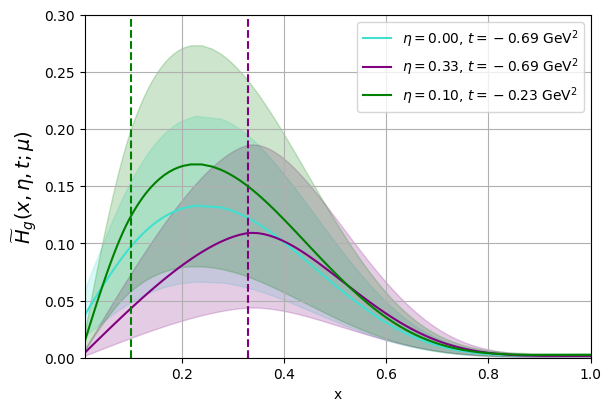

In [2]:
from stringy_gpds.plot import plot_gpds
import stringy_gpds.config as cfg
eta_array = cfg.ETA_ARRAY
t_array = cfg.T_ARRAY
mu_array = cfg.MU_ARRAY
colors = ["turquoise","purple","green"]
plot_gpds(eta_array,t_array,mu_array,colors,particle="gluon",gpd_type="singlet",gpd_label="Htilde",evolution_order="nlo",error_bars=True, read_from_file= False,write_to_file=True, y_0=0, y_1=.3,plot_legend=True)

Plots in impact parameter space

In [ ]:
# # The necessary dipole fits used for the impact
# # parameter space plots in the publication may be
# # generated using the code below. For the standard
# # parametrization used in the publication, they are
# # contained in the zenodo repository

# from stringy_gpds.fit import dipole_fit_moment
# from itertools import product
# # Optionally we can display the plot
# plot_fit = False
# # Set kinematics
# eta_vals = [0,.1,1/3]


# # Again, the tables used in the publication
# # are available on zenodo
# for eta, error_type, evolution_order in  product(eta_vals,["central","plus","minus"],["lo","nlo"]):
#     dipole_fit_moment(1,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(1,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(2,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(2,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(3,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(3,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(4,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(4,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(1,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(1,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(2,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(2,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(3,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(3,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(4,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(4,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(1,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(1,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(2,eta,2,particle="quark",moment_type="non_singlet_isovector",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(2,eta,2,particle="quark",moment_type="non_singlet_isoscalar",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(1,eta,2,particle="quark",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(1,eta,2,particle="gluon",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(2,eta,2,particle="quark",moment_type="singlet",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(2,eta,2,particle="gluon",moment_type="singlet",moment_label="A",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(2,eta,2,particle="quark",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(2,eta,2,particle="gluon",moment_type="singlet",moment_label="Atilde",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(2,eta,2,particle="quark",moment_type="singlet",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)
#     dipole_fit_moment(2,eta,2,particle="gluon",moment_type="singlet",moment_label="B",evolution_order=evolution_order,error_type=error_type,plot_fit=plot_fit)

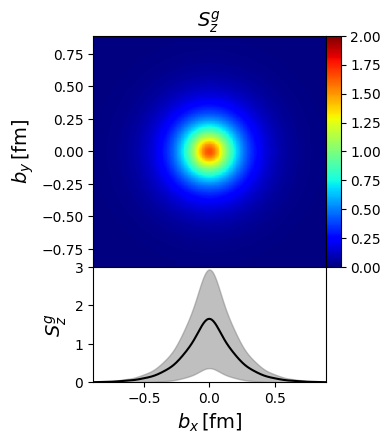

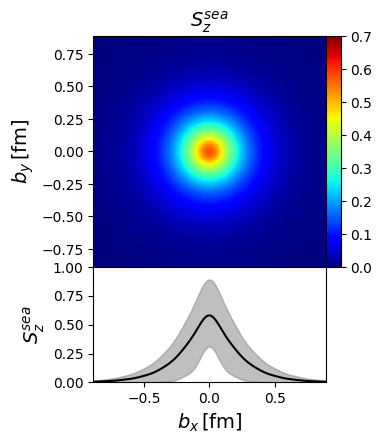

In [ ]:
from stringy_gpds.plot import plot_fourier_transform_singlet_helicity
plot_fourier_transform_singlet_helicity(0,2,particle="gluon",vmin=0,vmax=2,ymin=0,ymax=3,read_from_file=True,write_to_file=False)
plot_fourier_transform_singlet_helicity(0,2,particle="quark",vmin=0,vmax=.7,ymin=0,ymax=1,read_from_file=True,write_to_file=False)

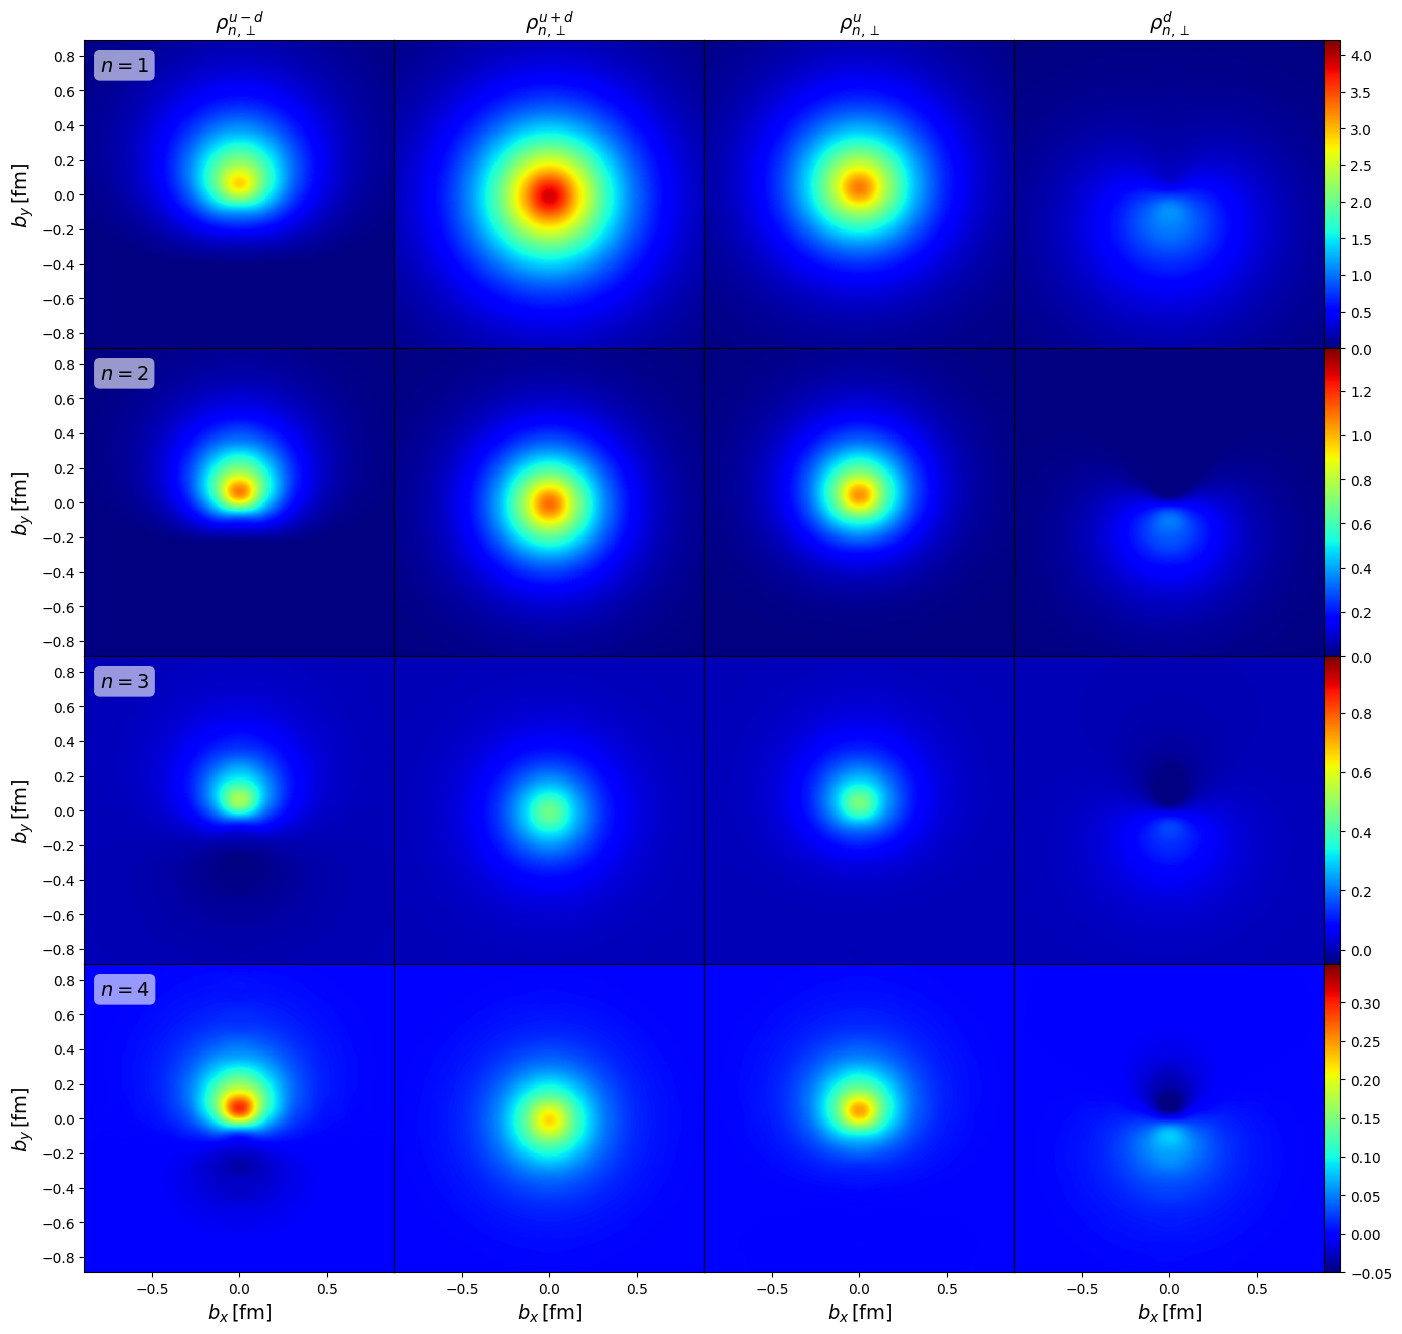

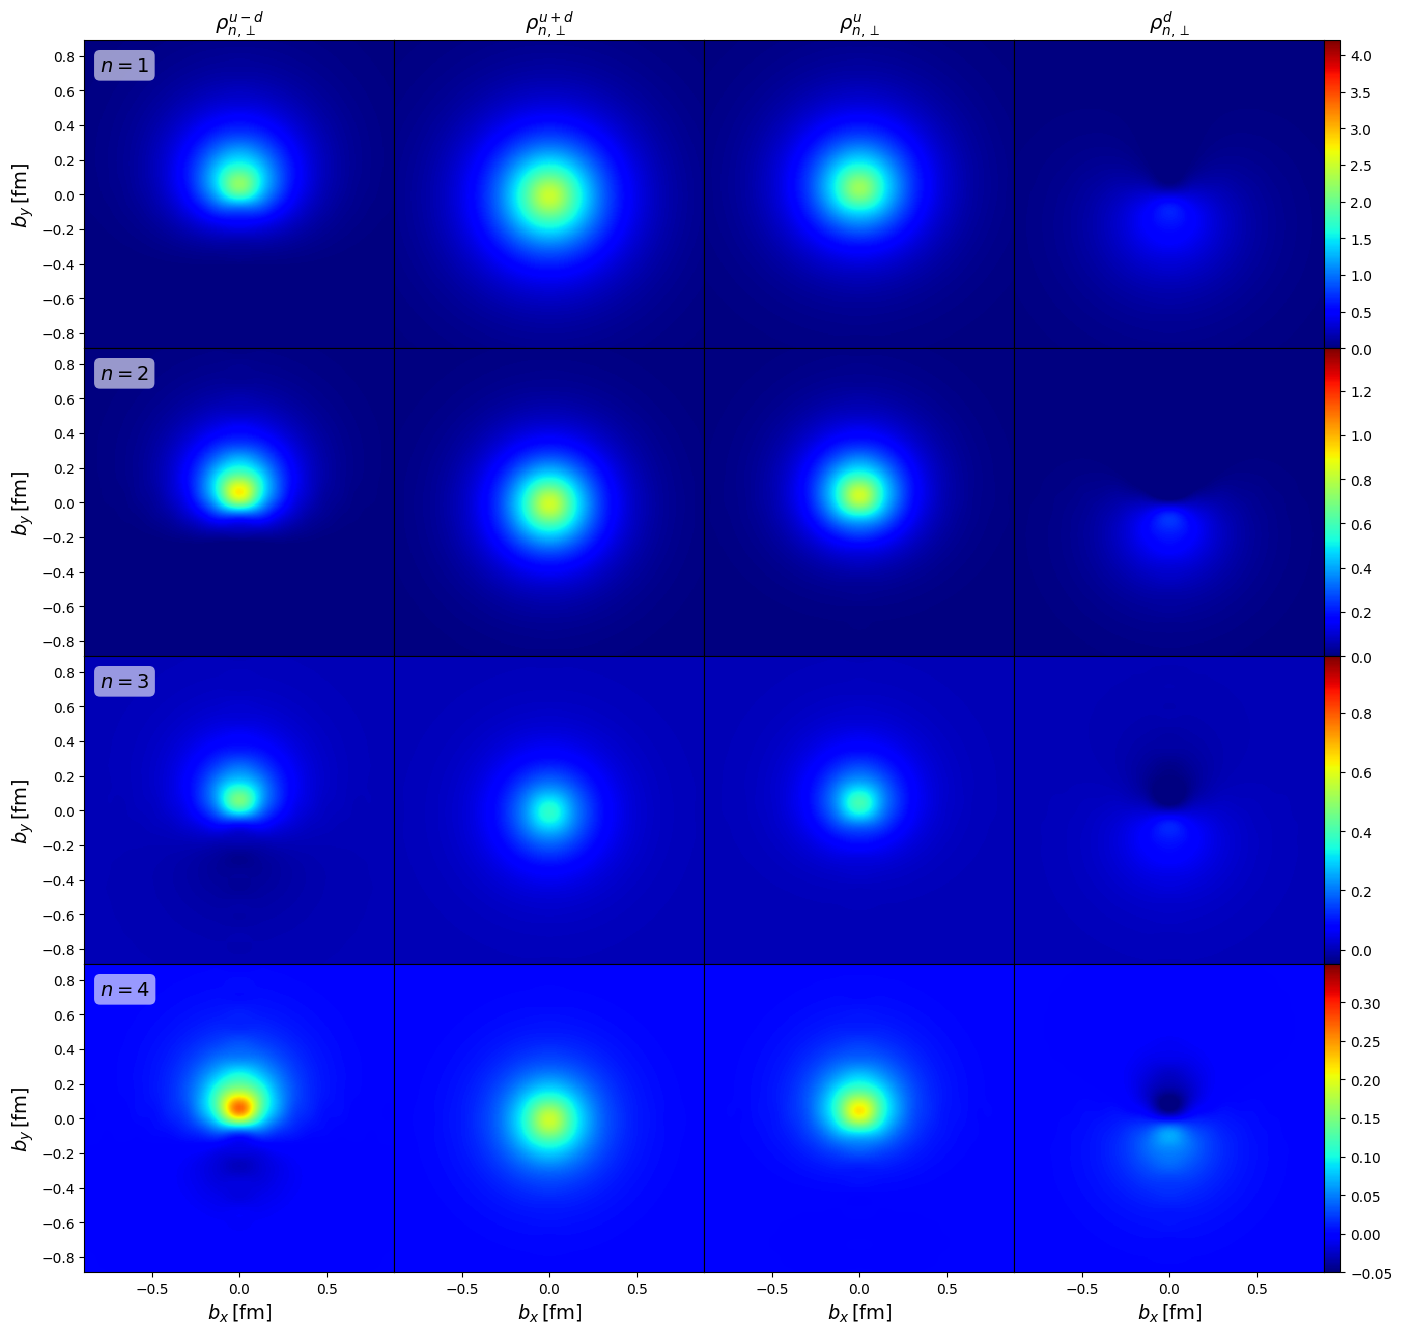

In [ ]:
# Generate data for transversely polarized
# proton in impact parameter space
# from stringy_gpds.plot import plot_fourier_transform_transverse_moments
# for eta in [0,.1,1/3]:
#     plot_fourier_transform_transverse_moments(1,eta,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=0, vmax=4.2,evolution_order="nlo")
#     plot_fourier_transform_transverse_moments(2,eta,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=0, vmax=1.4,evolution_order="nlo")
#     plot_fourier_transform_transverse_moments(3,eta,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=-.03, vmax=1,evolution_order="nlo")
#     plot_fourier_transform_transverse_moments(4,eta,2,moment_type="all",read_from_file=False,write_to_file=True,interpolation=True,vmin=-.03, vmax=.35,evolution_order="nlo")


from stringy_gpds.plot import plot_fourier_transform_transverse_moments_grid
# Zero skewness tomography
# plot_fourier_transform_transverse_moments_grid(4,0,2,vmin=[0,0,-0.05,-0.05],vmax=[4.2,1.39,.99,.349])
# Non-zero skewness tomography
plot_fourier_transform_transverse_moments_grid(4,.1,2,vmin=[0,0,-0.05,-0.05],vmax=[4.2,1.39,.99,.349])
plot_fourier_transform_transverse_moments_grid(4,.33,2,vmin=[0,0,-0.05,-0.05],vmax=[4.2,1.39,.99,.349])

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isovector_000_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isovector_000_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isovector_000_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isoscalar_000_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isoscalar_000_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_non_singlet_isoscalar_000_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_helicity_u_000_000_200.csv
Saved data to /home/hechenvanmountain/stringy-

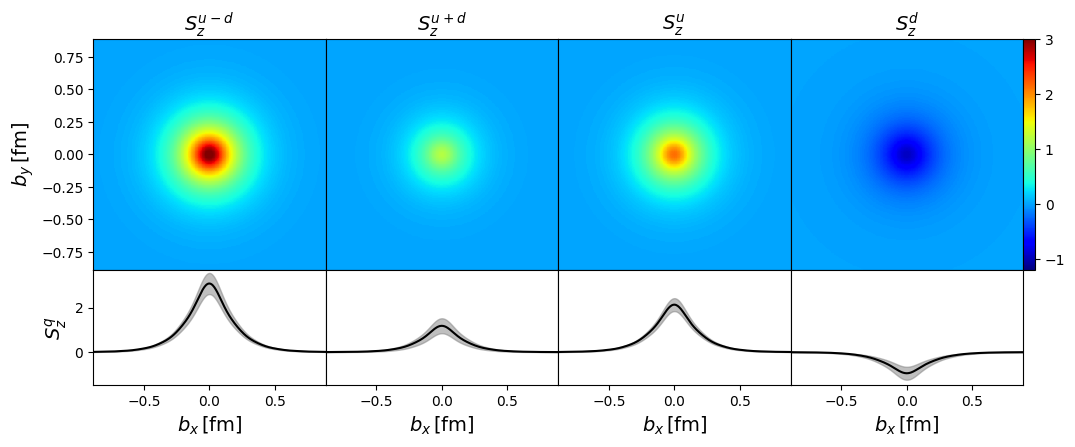

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isovector_000_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isovector_000_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isovector_000_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isoscalar_000_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isoscalar_000_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_non_singlet_isoscalar_000_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_spin_orbit_u_000_000_200.csv
Saved data to /home/hechenvanmou

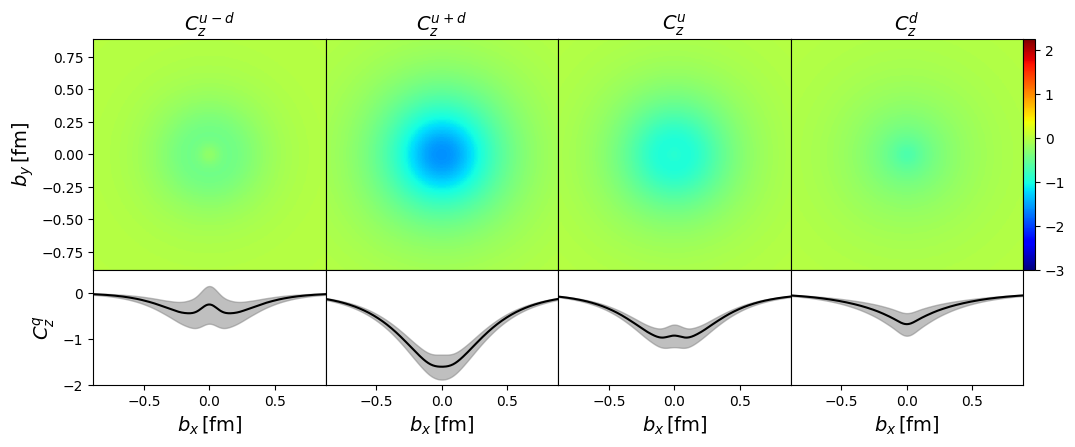

Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isovector_000_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isovector_000_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isovector_000_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isoscalar_000_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isoscalar_000_000_200_plus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_non_singlet_isoscalar_000_000_200_minus.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/imp_param_oam_u_000_000_200.csv
Saved data to /home/hechenvanmountain/stringy-gpds/data/ImpactParameterMoments/im

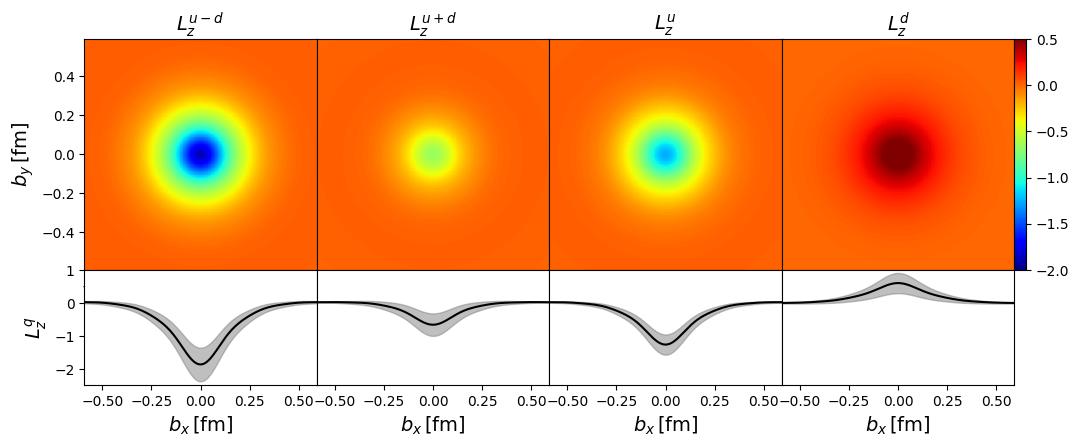

In [1]:
from stringy_gpds.plot import plot_fourier_transform_quark_helicity, plot_fourier_transform_quark_spin_orbit_correlation, plot_fourier_transform_quark_orbital_angular_momentum
plot_fourier_transform_quark_helicity(0,2,moment_type="all",read_from_file=False,write_to_file=True,ymin=-1.5,ymax=3.7,vmin=-1.2,vmax=3)
plot_fourier_transform_quark_spin_orbit_correlation(0,2,moment_type="all",read_from_file=False,write_to_file=True,ymin=-2,ymax=.5,vmin=-3,vmax=2.25)
plot_fourier_transform_quark_orbital_angular_momentum(0,2,moment_type="all",read_from_file=False,write_to_file=True,ymin=-2.5,ymax=1,vmin=-2,vmax=.5)

Spin sum rule quantities

In [ ]:
from stringy_gpds.core import (
    orbital_angular_momentum,spin_orbit_correlation,quark_helicity,gluon_helicity,total_spin
)
import numpy as np

In [ ]:
mu = 1
s_u_minus_d, s_u_minus_d_plus, s_u_minus_d_minus = quark_helicity(0,0,mu,moment_type="non_singlet_isovector")
s_u_plus_d, s_u_plus_d_plus, s_u_plus_d_minus = quark_helicity(0,0,mu,moment_type="non_singlet_isoscalar")
s_sea, s_sea_plus, s_sea_minus= quark_helicity(0,0,mu,moment_type="singlet")
s_g, s_g_plus, s_g_minus = gluon_helicity(0,0,mu)
s_u = (s_u_plus_d+s_u_minus_d)/2
s_u_plus = np.sqrt(s_u_minus_d_plus**2+s_u_plus_d_plus**2)/2
s_u_minus = np.sqrt(s_u_minus_d_minus**2+s_u_plus_d_minus**2)/2
s_d = (s_u_plus_d-s_u_minus_d)/2
s_s = s_sea - s_u - s_d
s_s_plus = np.sqrt(s_sea_plus**2 + 2 * s_u_plus**2)
s_s_minus = np.sqrt(s_sea_minus**2 + 2 * s_u_minus**2)
# print(s_u_minus_d,s_u_minus_d_minus,s_u_minus_d_plus)
# print(s_u_plus_d,s_u_plus_d_plus,s_u_plus_d_minus)
print("u")
print(s_u,s_u_plus,s_u_minus)
print("d")
print(s_d,s_u_plus,s_u_minus)
print("s")
print(s_s,s_s_plus,s_s_minus)
print("sea")
print(s_sea, s_sea_plus , s_sea_minus)
print("g")
print(s_g,s_g_plus,s_g_minus)
print(s_u+s_d+s_s+s_g,np.sqrt(2*s_u_plus**2+s_s_plus**2+s_g_plus**2),np.sqrt(2*s_u_minus**2+s_s_minus**2+s_g_minus**2))

u
0.42072267837761623 0.06650765755083389 0.06650765755083389
d
-0.20964013335007958 0.06650765755083389 0.06650765755083389
s
-0.026529818883290618 0.18491842204672548 0.18491842204672548
sea
0.18455272614424603 0.15921144992258848 0.15921144992258848
g
0.15600024702902826 0.1887690087130433 0.1887690087130433
0.34055297317327426 0.2804908171198371 0.2804908171198371


In [ ]:
mu = 1
l_u_minus_d, l_u_minus_d_plus ,l_u_minus_d_minus = orbital_angular_momentum(0,0,mu)
l_u_plus_d, l_u_plus_d_plus ,l_u_plus_d_minus = orbital_angular_momentum(0,0,mu,moment_type="non_singlet_isoscalar")
l_sea, l_sea_plus , l_sea_minus = orbital_angular_momentum(0,0,mu,moment_type="singlet")
l_g, l_g_plus, l_g_minus = orbital_angular_momentum(0,0,mu,moment_type="singlet",particle="gluon")
l_u = (l_u_minus_d + l_u_plus_d)/2
l_d = (l_u_plus_d - l_u_minus_d)/2
l_u_plus = np.sqrt(l_u_minus_d_plus**2+l_u_plus_d_plus**2)/2
l_u_minus = np.sqrt(l_u_minus_d_minus**2+l_u_plus_d_minus**2)/2
l_s = l_sea - l_u - l_d
l_s_plus = np.sqrt(l_sea_plus**2 + 2 * l_u_plus**2)
l_s_minus = np.sqrt(l_sea_minus**2 + 2 * l_u_minus**2)
# print(l_u_plus_d,l_u_plus_d_plus,l_u_plus_d_minus)
# print(l_u_minus_d,l_u_minus_d_plus,l_u_minus_d_minus)
print("u")
print(l_u,l_u_plus,l_u_minus)
print("d")
print(l_d,l_u_plus,l_u_minus)
print("s")
print(l_s,l_s_plus,l_s_minus)
print("sea")
print(l_sea, l_sea_plus , l_sea_minus)
print("g")
print(l_g,l_g_plus,l_g_minus)
print(l_u+l_d+l_s+l_g,np.sqrt(2*l_u_plus**2+l_s_plus**2+l_g_plus**2),np.sqrt(2*l_u_minus**2+l_s_minus**2+l_g_minus**2))

u
-0.07119123470138088 0.08668518039220174 0.08947018901381654
d
0.06643379526202971 0.08668518039220174 0.08947018901381654
s
0.14084175067045662 0.2093710429625069 0.2105375103624606
sea
0.13608431123110545 0.16972799601701186 0.16827422210572568
g
0.0233597851971859 0.20573063010311377 0.2030551480504693
0.15944409642829135 0.31810370446300884 0.3186961968140776


In [ ]:
mu = 1
j_u_minus_d, j_u_minus_d_plus, j_u_minus_d_minus =  total_spin(0,0,mu,particle="quark",moment_type="non_singlet_isovector",evolution_order="nlo")
j_u_plus_d, j_u_plus_d_plus, j_u_plus_d_minus =  total_spin(0,0,mu,particle="quark",moment_type="non_singlet_isoscalar",evolution_order="nlo")
j_sea, j_sea_plus, j_sea_minus =  total_spin(0,0,mu,particle="quark",moment_type="singlet",evolution_order="nlo")
j_g,j_g_plus,j_g_minus=  total_spin(0,0,mu,particle="gluon",moment_type="singlet",evolution_order="nlo")
j_u = (j_u_plus_d+j_u_minus_d)/2
j_u_plus = np.sqrt(j_u_minus_d_plus**2+j_u_plus_d_plus**2)/2
j_u_minus = np.sqrt(j_u_minus_d_minus**2+j_u_plus_d_minus**2)/2
j_d = (j_u_plus_d-j_u_minus_d)/2
j_s = j_sea - j_u - j_d
j_s_plus = np.sqrt(j_sea_plus**2 + 2 * j_u_plus**2)
j_s_minus = np.sqrt(j_sea_minus**2 + 2 * j_u_minus**2)
print("u")
print(j_u,j_u_plus,j_u_minus)
print("d")
print(j_d,j_u_plus,j_u_minus)
print("s")
print(j_s,j_s_plus,j_s_minus)
print("sea")
print(j_sea, j_sea_plus , j_sea_minus)
print("g")
print(j_g,j_g_plus,j_g_minus)
print(j_u + j_d + j_s +j_g,np.sqrt(2 * j_u_plus**2 + j_s_plus**2 + j_g_plus**2),np.sqrt(2 * j_u_minus**2 + j_s_minus**2 + j_g_minus**2))

u
0.34953144367623534 0.05559723002748939 0.05984685630230767
d
-0.14320633808804986 0.05559723002748939 0.05984685630230767
s
0.114311931787166 0.09819068600919861 0.10065396394267005
sea
0.3206370373753515 0.05881587239426017 0.054478693439125314
g
0.17936003222621416 0.08180069383641675 0.07481747455837429
0.49999706960156565 0.1500495528301746 0.1513015775701081


In [ ]:
c_u_minus_d, c_u_minus_d_plus, c_u_minus_d_minus = spin_orbit_correlation(0,2,mu,moment_type="non_singlet_isovector")
c_u_plus_d, c_u_plus_d_plus, c_u_plus_d_minus = spin_orbit_correlation(0,2,mu,moment_type="non_singlet_isoscalar")
c_u = (c_u_plus_d+c_u_minus_d)/2
c_u_plus = np.sqrt(c_u_minus_d_plus**2+c_u_plus_d_plus**2)/2
c_u_minus = np.sqrt(c_u_minus_d_minus**2+c_u_plus_d_minus**2)/2
c_d = (c_u_plus_d-c_u_minus_d)/2
print(c_u_minus_d,c_u_minus_d_minus,c_u_minus_d_plus)
print(c_u_plus_d,c_u_plus_d_plus,c_u_plus_d_minus)
print(c_u,c_u_plus,c_u_minus)
print(c_d,c_u_plus,c_u_minus)

-0.39844253802641905 0.17950598244725235 0.17043054856399925
-1.4625505084866472 0.17010833004615744 0.1792000831518223
-0.9304965232565332 0.12039872905778339 0.12682179183402717
-0.532053985230114 0.12039872905778339 0.12682179183402717


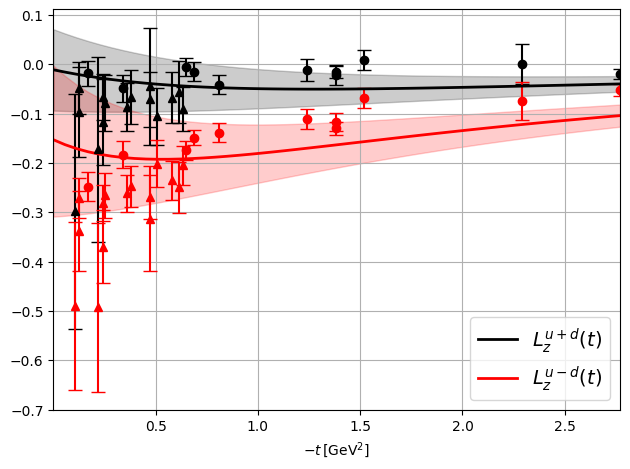

In [ ]:
from stringy_gpds.plot import plot_orbital_angular_momentum
plot_orbital_angular_momentum(0,2,evolution_order="nlo")

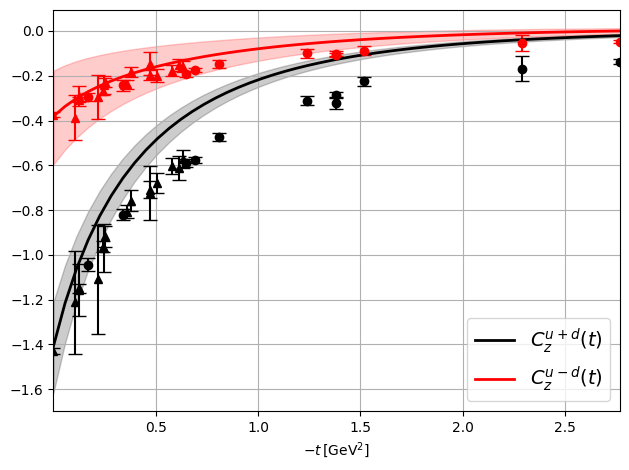

In [ ]:
from stringy_gpds.plot import plot_spin_orbit_correlation
plot_spin_orbit_correlation(0,2,evolution_order="nlo")